In [1]:
import numpy as np
import scipy.linalg as la
import pandas as pd

from scipy.optimize import newton
from scipy.interpolate import CubicSpline
from scipy.interpolate import CubicSpline
from scipy.signal import find_peaks  # Para detectar máximos

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Seccion Astronomica

# Ajuste kepleriano desde velocidad radial

**Objetivo:** A partir de curvas de velocidad radial (VR), estimar  y derivar:

- P: Periodo, tiempo que tarda una estrella en completar una órbita alrededor de la otra.

- *e* : Excentricidad del periastro.
- ω : Argumento del periastro.
- γ : Velocidad sistemica (desplazamiento vertical)
- Semi amplitud de las estrellas:
 $$K_{1}$$
$$ K_{2}$$
- De lo anterior se puede estimar la relacion de masas de las estrellas
$$
q = \frac{K{1}}{K{2}}
$$



## Datos de entrada:
Dos array de datos correspondientes a cada estrella:

- Arrays de tiempo (dias)
- Velocidades radiales de las dos estrellas en el sistema (Km/s)

$$v_{1}$$
$$v_{2}$$

- i : inclinación del plano orbital de las estrellas respecto al observador.

El primer paso consiste en estimar una curva de velocidad radial, esto con los datos obtenidos experimental. Se encontro v(t) con metodos de interpolación (CubicSpline)

In [2]:
def Periodo(t , v , n=1000):
  '''
  Mediante interpolación se estima la curva de velocidad radial, al ser una funcion periodica, el periodo consta del promedio entre los picos.

  Entradas:
    t : array de tiempo
    v : array de velocidad radial
    n : Cantidad de puntos a interpolar

  Salida:
    P : Periodo orbital
  '''

  # Interpolación con CubicSpline
  v_spline = CubicSpline(t, v)

  t_interp = np.linspace(t.min(), t.max(), n)
  v_interp = v_spline(t_interp)  # velocidad interpolada

  # Encontrar máximos
  peaks, _ = find_peaks(v_interp)  # índices donde hay máximos
  t_peaks = t_interp[peaks]        # tiempos de los picos

  # Calcular periodo
  P_est = np.mean(np.diff(t_peaks))  # promedio entre distancias de picos

  return P_est

Periodo estimado: 4.135135135135135 días


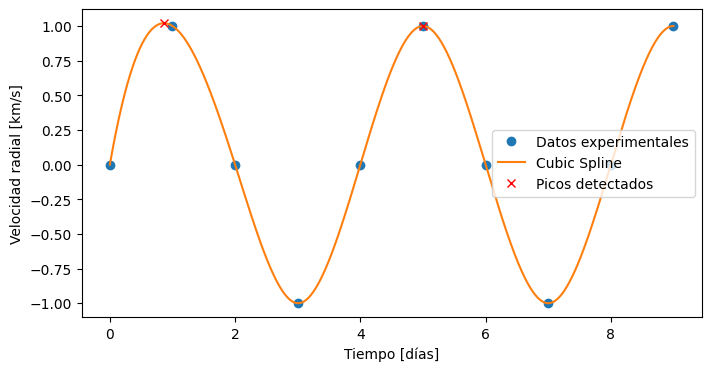

In [3]:
# Datos experimentales (ejemplo)
t = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])        # tiempo [días]
v = np.array([0.0, 1.0, 0.0, -1.0, 0.0, 1.0, 0.0, -1.0, 0.0, 1.0])  # velocidad [km/s]

# Interpolación con CubicSpline
v_spline = CubicSpline(t, v)

t_interp = np.linspace(t.min(), t.max(), 1000)
v_interp = v_spline(t_interp)  # velocidad interpolada

# Encontrar máximos
peaks, _ = find_peaks(v_interp)  # índices donde hay máximos
t_peaks = t_interp[peaks]        # tiempos de los picos

# Calcular periodo
P_est = Periodo(t , v)

print("Periodo estimado:", P_est, "días")

# 6. Graficar
plt.figure(figsize=(8,4))
plt.plot(t, v, "o", label="Datos experimentales")
plt.plot(t_interp, v_interp, "-", label="Cubic Spline")
plt.plot(t_peaks, v_interp[peaks], "rx", label="Picos detectados")
plt.xlabel("Tiempo [días]")
plt.ylabel("Velocidad radial [km/s]")
plt.legend()
plt.show()


El siguiente paso, consiste en encontrar el valor K
$$
K = \frac{v_{max}-v_{min}}{2}
$$

De otro lado, la velocidad sistemica, γ, hace referencia a la velocidad del baricentro del sistema respecto al observador.
De otro lado, con el valor de K se puede obtener la relacion de masas en el sistema:

$$
q = \frac{M2}{M1} = \frac{K2}{K1}
$$



In [4]:
def K_gamma(t, v, P, t0=None, n=2000):
  '''
  Estima K y gamma de una curva de velocidad radial, graficando en una fase orbital, es decir, el punto de la orbita en la que se encuentra la estrella
  Fase = (ti - t0)/P
  Donde t0 es un tiempo de referencia (por ejemplo, el paso por el peri-astro)

  Entradas:
    t : array (días)
    v : array (km/s)
    P : float, periodo (días) común a ambas estrellas
    t0 : float o None, tiempo de referencia
    n : int, puntos de evaluación en fase [0,1]

  Devuelve:
    K : float (km/s)
    gamma : float (km/s)
    vmax, vmin : extremos de la spline (km/s)
  '''

  t = np.array(t)
  v = np.array(v)

  if t0 is None:
    t0 = t.min()

  # 1) Fase
  phase1 = ((t - t0) / P) % 1.0      # Se realiza el array de fases y obtiene el residuo de dividir por 1, para obtener la fase en la que se encuentra y no cuantos periodos se repitieron (ejemplo 3.7, pasaron 3 periodos y esta en fase 0.7 )
  i = np.argsort(phase1)             # Se organiza el array de fase en orden acendente (segun los indices)
  phase = phase1[i]; v_phase = v[i]  # Se crea un array ordenado con los indices antes ordenados

  # 2) Spline cúbica periódica en fase, para poder asegurara una continuidad para fase 0 y 1, duplicamos primer punto al final con fase+1 para continuidad 0=1)
  phi = np.concatenate([phase, [phase[0] + 1.0]]) # Se hace una copia del array de phase, pero con un elemento adicional al extremo (fase = 1), con el mismo valor de velocidad radial asociado
  v_ext = np.concatenate([v_phase, [v_phase[0]]])
  v_spline = CubicSpline(phi, v_ext, bc_type='periodic')

  # 3) Evaluar y hallar extremos
  phi_interp = np.linspace(0, 1, n)
  v_interp = v_spline(phi_interp)
  imax = np.argmax(v_interp) # Indices donde v se minimisa o maximiza
  imin = np.argmin(v_interp)
  vmax = v_interp[imax] # valor minimmo o maximo de v
  vmin = v_interp[imin]

  # 4) K y gamma
  K = 0.5 * (vmax - vmin)
  gamma = 0.5 * (vmax + vmin)

  return K, gamma, vmax, vmin

def Ks_SB2(t, v1, v2, P, t0=None, n=2000):
  '''
  Estima K1, K2 y gammas (y razón de masas) para un sistema binario.

  Entradas:
    t : array (días)
    v1 y v2 : array (km/s)
    P : float, periodo (días) común a ambas estrellas
    t0 : float o None, tiempo de referencia
    n : int, puntos de evaluación en fase [0,1]

  Devuelve:
    out : diccionario con K1, K2, gamma1, gamma2, relacion de masas, vmax y vmin para cada estrella
  '''

  K1, g1, vmax1, vmin1 = K_gamma(t, v1, P, t0, n)
  K2, g2, vmax2, vmin2 = K_gamma(t, v2, P, t0, n)

  # Razón de masas: q = M2/M1 = K1/K2
  q = K1 / K2

  out = {"K1": K1, "K2": K2,
        "gamma1": g1, "gamma2": g2,
        "Razón de masas(q)": q,
        "Diagnostico": {"v1": {"vmax": vmax1, "vmin": vmin1},
                        "v2": {"vmax": vmax2, "vmin": vmin2}}}

  return out

# Modelo kepleriano de velocidad radial
Para cada estrella (índice 1 y 2) en un sistema binario con órbita kepleriana común:
$$
v_{1}(t) = \gamma_{1} + K_{1} [cos(\theta(t) + w) +e\cdot cos(w)]
$$
$$
v_{2}(t) = \gamma_{2} + K_{2} [cos(\theta(t) + w) +e\cdot cos(w)]
$$

donde θ(t)corresponde a la anaomaliaa verdadera, que sale de resolver las siguientes ecuaciones de Kepler:

$$
M =  \frac{2 π(t -T_{0})}{P}
$$
$$
M = E - e\cdot sin(E)
$$
$$
θ= 2\cdot arctan(tan(\frac{E}{2})\cdot \sqrt{\frac{1 + e}{1 - e}})
$$

In [5]:
# Salucion a las ecuaciones de Kepler para encontrar theta(t)
Kepler = lambda E , M , e : E - e*np.sin(E) - M

dKepler_dE = lambda E , e : 1 - e*np.cos(E)

def sol_kepler(M, e):
  '''
  Resuelve la ecuación de Kepler usando el metodo newton de scipy.optimize.
  '''
  return newton(lambda E: Kepler(E, M, e),
              x0 = M,
              fprime = lambda E: dKepler_dE(E, e))



# Modelo toerico de las velocidades radiales
# Velocidades radiales
def vr_model(t, P, e, omega, T0, K1, K2, gamma1, gamma2):
  '''
  Calcula las velocidades radiales de ambas estrellas en un sistema binario espectroscópico doble (SB2).

  Entradas:
  - t : array de tiempos [días]
  - P : periodo orbital [días]
  - e : excentricidad
  - omega : argumento del periastro [rad]
  - T0 : tiempo de periastro [días]
  - K1, K2 : semi-amplitudes [km/s]
  - gamma1 : velocidad sistémica de la estrella 1 [km/s]
  - gamma2 : velocidad sistémica de la estrella 2 [km/s]

  Salidas:
  - v1, v2 : arrays de velocidades radiales para ambas estrellas [km/s]
  '''
  # 1) Anomalía media
  M = 2*np.pi/P * (t - T0)

  # 2) Resolver ecuación de Kepler para cada M
  E = np.array([sol_kepler(Mi, e) for Mi in M])  # anomalía excéntrica

  # 3) Anomalía verdadera
  theta = 2*np.arctan2(np.sqrt(1+e)*np.sin(E/2),
                       np.sqrt(1-e)*np.cos(E/2))

  # 4) Velocidades radiales
  v1 = gamma1 + K1 * (np.cos(theta + omega) + e*np.cos(omega))
  v2 = gamma2 - K2 * (np.cos(theta + omega) + e*np.cos(omega))

  return v1, v2

Para este punto, hace falta calcular el valor de e (exentricidad), ω (argumento del periastro). Para esto, se realizara una buscqueda para cada posible valor, de modo que se realaizara una curva de velocidad radial para cada posible valor de e y ω, al encontrar la curva con el menor error cuadratico se puede devolver la estimacion de los valores de e y ω

In [6]:
def estimar_e_omega(t, v1_obs, v2_obs, P, K1, K2, gamma1 , gamma2, t0=None, e_grid=np.linspace(0, 0.9, 50), omega_grid=np.linspace(0, 2*np.pi, 50)):
  '''
  Estima e y omega (argumento del periastro) para un sistema binario.

  Entradas:
    t : array de tiempos (días)
    v1_obs, v2_obs : velocidades radiales observadas [km/s]
    P : periodo orbital [días]
    K1, K2 : semi-amplitudes [km/s]
    gamma1 , gamma2 : velocidad sistémica [km/s]
    t0 : tiempo de periastro (días). Si None, se toma t.min()
    e_grid : malla de valores de excentricidad
    omega_grid : malla de valores de ω [rad]

  Salida:
    best_e, best_omega : valores óptimos
    '''
  if t0 is None:
    t0 = t.min()

  best_e, best_omega = None, None
  best_error = np.inf

  for e in e_grid:
    for omega in omega_grid:
      # Modelo de velocidades
      v1_model, v2_model = vr_model(t, P, e, omega, t0, K1, K2, gamma1 , gamma2)

      # error
      error = np.sum((v1_obs - v1_model)**2 + (v2_obs - v2_model)**2)

      if error < best_error:
        best_error = error
        best_e, best_omega = e, omega

  return best_e, best_omega

# Parametros fisicos del sistema


## Semiejes mayores proyectados
$$
a_{1}sin(i) = \frac{K_{1}P}{2π}\cdot \sqrt{1 - e^{2}}
$$

$$
a_{2}sin(i) = \frac{K_{2}P}{2π}\cdot \sqrt{1 - e^{2}}
$$

De este modo, el semi eje relativo proyectado hace referencia a:

$$
a\cdot sin(i) = (a_{1}+a_{2})sin(i)
$$

In [7]:
# Constantes
dias_s = 86400.0           # Conversion de dias a segundos
km_m = 1000.0              # Convercion de km a m
G = 6.67430e-11            # m^3 kg^-1 s^-2
M_SUN = 1.98847e30         # kg
AU = 1.495978707e11        # m

In [8]:
def semi_ejes(t, v1, v2, t0=None, n=2000):
  '''
  Calcula los semiejes proyectados (a1*sin(i), a2*sin(i)) en AU
  a partir de los datos de velocidades radiales de un sistema binario.

  Pasos:
  1. Se estima el periodo orbital con la función Periodo.
  2. Se calculan K1, K2 y gammas con Ks_SB2.
  3. Se estima la excentricidad (e) y argumento del periastro (omega).
  4. Se calculan los semiejes usando la ecuadión

  Entradas:
    t : array de tiempos [días]
    v1, v2 : arrays de velocidades radiales [km/s]
    t0 : tiempo de referencia (paso por periastro, opcional)
    n : puntos de interpolación en fase

  Salidas:
    dict con a1*sin(i), a2*sin(i), (a1 + a2)*sin(i), K1, K2, P, e
    '''

  # 1) Periodo orbital
  P = Periodo(t, v1, n=n)

  # 2) Semi-amplitudes y gamma
  resultados = Ks_SB2(t, v1, v2, P, t0=t0, n=n)
  K1 = resultados["K1"]
  K2 = resultados["K2"]
  gamma1 = resultados["gamma1"]
  gamma2 = resultados["gamma2"]

  # 3) Estimación de excentricidad y omega
  e, omega = estimar_e_omega(t, v1, v2, P, K1, K2, resultados["gamma1"], resultados["gamma2"], t0=t0)

  # 4) Cálculo de semiejes
  a1_sini = ((K1*km_m * P*dias_s)/(2*np.pi * AU)) * np.sqrt(1 - e**2)
  a2_sini = ((K2*km_m * P*dias_s)/(2*np.pi * AU)) * np.sqrt(1 - e**2)
  a_total = a1_sini + a2_sini

  return {"P[dias]": P,
          "K1[km/s]": K1,
          "K2[km/s]": K2,
          "e": e,
          "omega[rad]": omega,
          "a1_sin(i)[AU]": a1_sini,
          "a2_sin(i)[AU]": a2_sini,
          "(a1+a2)_sin(i)[AU]": a_total}

## Masas de las estrellas

- Por 3ra ley de Kepler:

$$
M_{1}+ M_{2} = \frac{4π^2 a^3}{GP^2}
$$

- Por baricentro:

$$
M_{1}a_{1} = M_{2}a_{2}
$$

De lo anterior se tiene que:

$$
M_{1} = M_{total}\frac{a_2}{a_1 + a_2}
$$

$$
M_{2} = M_{total}\frac{a_1}{a_1 + a_2}
$$

In [9]:
def masas(t, v1, v2, i, t0=None, n=2000):
  '''
  Calcula las masas M1 y M2 en masas solares de un sistema binario.
  Proceso:
    1) Obtiene P, K1, K2, e, omega, a1·sin i, a2·sin i con semi_ejes().
    2) Aplica la 3ª ley de Kepler para calcular M_total.
    3) Usa la condición de baricentro (M1·a1 = M2·a2) para separar M1 y M2.

  Entradas:
    - t : array de tiempos [días]
    - v1, v2 : arrays de velocidades radiales [km/s]
    - i : inclinación orbital [rad]
    - t0 : tiempo de referencia (periastro)
    - n : Cantidad de puntos a interpolar

  Devuelve:
    - diccinario con M1, M2 y M_total
  '''

  # 1) semiejes y parámetros orbitales
  resultados = semi_ejes(t, v1, v2, t0=t0, n=n)
  P = resultados["P[dias]"]
  a1_sini = resultados["a1_sin(i)[AU]"]
  a2_sini = resultados["a2_sin(i)[AU]"]

  # 2) pasar a metros y desproyectar
  a1 = (a1_sini / np.sin(i)) * AU
  a2 = (a2_sini / np.sin(i)) * AU
  a_total = a1 + a2

  # Periodo en segundos
  P_seg = P * dias_s

  # 3) masa total (kg)
  M_total = (4 * np.pi**2 * a_total**3) / (G * P_seg**2)

  # 4) repartir masas
  M1 = M_total * (a2 / (a1 + a2))
  M2 = M_total * (a1 / (a1 + a2))

  # Retornamos las masas convertidas a masas solares
  return {"M1[M_sun]": M1 / M_SUN,
          "M2[M_sun]": M2 / M_SUN,
          "M_total[M_sun]": M_total / M_SUN}

# Graficar el sistema binario

Se utilizo coordenadas polares
$$
r_i(t) = \frac{a_i(1 - e^2)}{1+e\cdot cos(θ(t))}
$$

In [10]:
def graficar_orbitas_polares(t, v1, v2, i, t0=None, n=2000):
  # Parámetros orbitales y semiejes
  resultados = semi_ejes(t, v1, v2, t0=t0, n=n)
  P = resultados["P[dias]"]
  e = resultados["e"]
  omega = resultados["omega[rad]"]
  a1 = (resultados["a1_sin(i)[AU]"] / np.sin(i))
  a2 = (resultados["a2_sin(i)[AU]"] / np.sin(i))

  # Anomalía media
  M = 2*np.pi* (t - (t0 if t0 else t.min()))/P

  # Resolver Kepler y hallar theta
  E = np.array([sol_kepler(Mi, e) for Mi in M])
  theta = 2*np.arctan2(np.sqrt(1+e)*np.sin(E/2),
                         np.sqrt(1-e)*np.cos(E/2))

  # Radios en polares
  r1 = a1 * (1 - e**2) / (1 + e*np.cos(theta))
  r2 = a2 * (1 - e**2) / (1 + e*np.cos(theta))

  return {'theta1': theta+omega, 'R_M1': r1, 'theta2': theta+omega+np.pi, 'R_M2': r2}

# Simulación

In [11]:
path = 'D:\\UdeA\\Semestre 3\\Metodos\\Proyecto\\Chapy AB\\binary_rv_simulation (1).xlsx'

metadata = pd.read_excel(path, sheet_name=0)
data = pd.read_excel(path, sheet_name=1)

display(metadata, data)

,parameter,value
0,inclination_radians,0.85
1,M1_solar_masses,1.20
2,M2_solar_masses,0.90
3,period_days,30.00
4,eccentricity,0.25
5,omega_degrees,60.00


,day,v_star_1_km_s,v_star_2_km_s
0,0.000000,18.236828,-24.315771
1,1.139241,7.064673,-9.419564
2,2.278481,-3.978173,5.304230
3,3.417722,-13.005133,17.340177
4,4.556962,-19.363473,25.817964
...,...,...,...
75,85.443038,30.690906,-40.921208
76,86.582278,32.723987,-43.631983
77,87.721519,31.851642,-42.468855
78,88.860759,27.034503,-36.046004


In [12]:

i = metadata.loc[metadata['parameter'] == 'inclination_radians', 'value'].item()
day = np.array(data['day'])
v1 = np.array(data['v_star_1_km_s'])
v2 = np.array(data['v_star_2_km_s'])

In [13]:
parametros = semi_ejes(day , v1 , v2)
parametros = parametros = pd.DataFrame(list(parametros.items()), columns=["parameter", "value"])
parametros

,parameter,value
0,P[dias],30.007504
1,K1[km/s],29.179220
2,K2[km/s],38.905626
3,e,0.257143
4,omega[rad],1.025826
5,a1_sin(i)[AU],0.077778
6,a2_sin(i)[AU],0.103704
7,(a1+a2)_sin(i)[AU],0.181482


In [14]:
masas_datos = masas(day , v1 , v2 , i)
masas_datos = pd.DataFrame(list(masas_datos.items()), columns=["parameter", "value"])
masas_datos

,parameter,value
0,M1[M_sun],1.193386
1,M2[M_sun],0.895040
2,M_total[M_sun],2.088426


In [15]:
puntos = graficar_orbitas_polares(day , v1 , v2 , i)
puntos = pd.DataFrame(puntos)
puntos.insert(0, 'dia', data['day'])
puntos

,dia,theta1,R_M1,theta2,R_M2
0,0.000000,1.025826,0.076906,4.167419,0.102541
1,1.139241,1.438726,0.078251,4.580319,0.104335
2,2.278481,1.825503,0.081988,4.967096,0.109318
3,3.417722,2.171142,0.087405,5.312735,0.116540
4,4.556962,2.473078,0.093712,5.614671,0.124950
...,...,...,...,...,...
75,85.443038,5.856208,0.093841,8.997800,0.125122
76,86.582278,6.157314,0.087523,9.298907,0.116698
77,87.721519,6.502080,0.082082,9.643673,0.109443
78,88.860759,6.888144,0.078304,10.029736,0.104405


In [ ]:
def esf_cart(r, theta):
    ''' Combierte coordenadas polares en coordenadas cartesianas
    
    Entradas:
    - r: longitud del vector
    - theta: con el eje x [0, 2π]
    
    Salidas:
    - x, y: valores del vector en base cartesiana'''

    x = r *np.cos(theta)  # Usar phi para polar
    y = r *np.sin(theta)
    
    return x, y

def cart_esf(x, y):
    ''' Combierte coordenadas cartesianas en coordenadas polares
    
    Entradas:
    - x, y: valores del vector en base cartesiana
 
    Salidas:
    - r: longitud del vector
    - theta: angulo con el eje x[0, 2π]'''
    
    if x == 0 and y == 0:
        return 0,0

    r = la.norm([x, y])
    theta = np.arctan2(y, x)
    if theta < 0:
        theta += 2*np.pi
    
    return r, theta

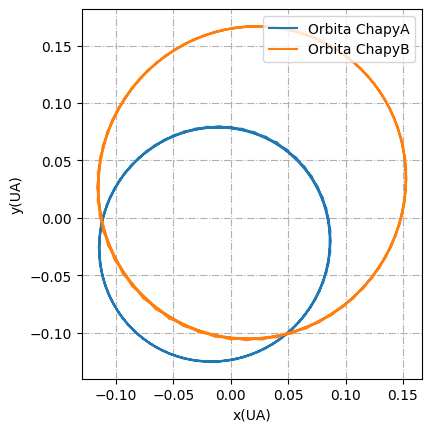

In [17]:
x1, y1 = esf_cart(puntos['R_M1'], puntos['theta1'])
x2, y2 = esf_cart(puntos['R_M2'], puntos['theta2'])

plt.grid(linestyle= '-.')

plt.plot(x1, y1, label = 'Orbita ChapyA')
plt.plot(x2, y2, label = 'Orbita ChapyB')

plt.xlabel('x(UA)')
plt.ylabel('y(UA)')

plt.gca().set_aspect("equal", adjustable="box")
plt.legend(loc="upper right")

In [18]:
fig, ax = plt.subplots()
E1 = ax.scatter([], [])
E2 = ax.scatter([], [])

ax.set_title('Simulacion del sistema Chapy AB')

ax.set_xlabel('x(AU)')
ax.set_ylabel('y(AU)')

ax.legend()

ax.set_xlim(-0.15, 0.2)
ax.set_ylim(-0.15, 0.2)


def init():
    E1.set_offsets([x1[0], y1[0]])
    E2.set_offsets([x2[0], y2[0]])

    return E1, E2

def update(frame):
    E1.set_offsets([x1[frame], y1[frame]])
    E2.set_offsets([x2[frame], y2[frame]])

    return E1, E2

E1.set_label('Chapy A')
E2.set_label('Chapy b')

ax.legend()

ani = FuncAnimation(fig, update, frames= len(day), init_func= init)
ax.set_aspect("equal", "box")

plt.close()
HTML(ani.to_jshtml())

C:\Users\luisd\AppData\Local\Temp\ipykernel_12640\3256647126.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


# Seccion Fisica

Se define como potencial gravitacional a la ecuacion, en coordenadas esfericas

$$ φ_g = \frac{GM}{ρ} $$

donde: 
- G = Constante gravitacional (6.674 x 10⁻¹¹)
- M = Masa del cuerpo generador
- r = Distancia de la masa almpunto donde se evalua el campo

Asi pues, encontrando el gradiente podemos encontrar el campo gravitatorio para la masa M es el gradiente del potencial gravitatorio

$$ \nabla φ_g = \frac{\partial φ_g}{\partial r}\hat{e_{r}} + \frac{\partial φ_g}{\partial \theta}\hat{e_{\theta}} + \frac{\partial φ_g}{\partial \phi}\hat{e_{\phi}} $$

Como no hay componentes $\theta$, $\phi$, el campo solo dependera de la componente $ρ$

de forma analitica:

$$ \nabla φ_g = \frac{GM}{ρ^2}\hat{e_{r}}$$


In [ ]:
P_gravitatorio = lambda r, M: -G*M/r

def F_campo(r_p, theta_p, M, r_m = 0, theta_m = 0):
    ''' Calcula el campo gravitatorio en un punto en coordenadas polares partiendo del potencial gravitatorio
    
    Entradas:
    - r_p, theta_p: Coordenadas polares del punto en que se va a evaluar el campo
    - M: Masa del cuerpo que genera el campo
    - r_m, theta_m: Coordenadas polares de la ubicacion del cuerpo generador (por defecto se considera en (0, 0))
    
    Salidas
    - intensidad: Magnitud del vector de campo en el punto evaluado
    - theta: angulo con el eje x'''
    
    xp, yp = esf_cart(r_p, theta_p)

    xc, yc = esf_cart(r_m, theta_m)

    xp -= xc
    yp -= yc

    r, theta = cart_esf(xp, yp)

    if r <= 0:
        raise ValueError('r debe ser positivo mayor que 0')
    elif r<=1000:
        r_values = np.arange(r , r +1000, 1)
    else:
        r_values = np.arange(r -1000, r +1000, 1)
    
    campo_grav = np.gradient(P_gravitatorio(r_values, M), 1, edge_order= 2)

    intensidad = -CubicSpline(r_values, campo_grav, bc_type= 'natural')(r)

    return intensidad, theta

F_campo(6.371e6, 0, 5.9722e24)


(np.float64(-9.820302292704582), np.float64(0.0))

Teniendo 2 masas en el espacio, orbitandoce entre si alrededor de un centro de masa, el campo gravitacional del sistema puede entenderse como el campo gravitacional generado por la suma de sus masas en ese punto, sin embargo esto solo sera valido para distancias largas, pues el campo gravitacional local se distorciona pues el ampo real es la suma de los campos generados por amas partes, Para el ejemplo tomemos un tiempo albitrario del sistema ChapyAB

In [ ]:
def malla_vector(P1, P2, M1, M2, xy_rang = 1*AU):
    '''Crea una malla de vectores de campo de 10x10 vectores dentro del rango xy
    
    Entradas:
    -P1, P2: puntos donde se ubican las masas 1 y 2
    -M1, M2: Masas de los cuerpos
    -xy_rang: Rango de la malla (por defecto en 1AU)

    Salidas:
    -xP_vector, yP_vector: istas de con de se ubican los origenes de los vectores en sus respectivas componentes
    -xC_vector, yC_vector: istas de los componentes x, y de los vectores para cada punto (normalizados)
    -Intensidades: lista de colores para cada vector dado el caso de querer aplicar un mapa de color
    -cmap: Mapa de colores de los vectores
    -norm: Regla de asignacion de los colores
    -magnitudes: magnitudes reales de los vectores'''

    x_vals = np.linspace(-xy_rang, xy_rang, 10, dtype= float)
    y_vals= np.linspace(-xy_rang, xy_rang, 10, dtype= float)

    xM, yM = P1
    rM, tM = cart_esf(xM, yM)

    xM2, yM2 = P2
    rM2, tM2 = cart_esf(xM2, yM2)

    rC_min = float("inf")
    rC_max = float("-inf")

    for x in x_vals:
        for y in y_vals:
            xP, yP = x, y
            rP, tP = cart_esf(xP, yP)
            rC, tC = F_campo(rP, tP, M1, r_m=rM, theta_m=tM) 
            xC, yC = esf_cart(rC, tC)

            rC2, tC2 = F_campo(rP, tP, M2, r_m=rM2, theta_m=tM2) 
            xC2, yC2 = esf_cart(rC2, tC2)        

            xC_total, yC_total = xC2 + xC, yC2 + yC

            intensidad = la.norm([xC_total, yC_total])

            if intensidad < rC_min:
                rC_min = intensidad
            if intensidad > rC_max:
                rC_max = intensidad

    cmap = cm.jet
    norm = colors.LogNorm(vmin=rC_min, vmax=rC_max  )

    xP_vector = []
    yP_vector = []

    xC_vector = []
    yC_vector = []

    intensidades = []

    magnitudes = []

    for x in x_vals:
        for y in y_vals:
            xP, yP = x, y
            rP, tP = cart_esf(xP, yP)

            rC, tC = F_campo(rP, tP, M1, r_m= rM, theta_m= tM)
            xC, yC = esf_cart(rC, tC)

            rC2, tC2 = F_campo(rP, tP, M2, r_m=rM2, theta_m=tM2) 
            xC2, yC2 = esf_cart(rC2, tC2)        

            xC_total, yC_total = xC2 + xC, yC2 + yC

            intensidad = la.norm([xC_total, yC_total])
            color = cmap(norm(intensidad))
            
            xC_total, yC_total = np.array([xC2 + xC, yC2 + yC])/la.norm([xC2 + xC, yC2 + yC])

            xP_vector.append(xP)
            yP_vector.append(yP)

            xC_vector.append(xC_total)
            yC_vector.append(yC_total)

            intensidades.append(color)

            magnitudes.append(intensidad)
    
    return xP_vector, yP_vector, xC_vector, yC_vector, intensidades, cmap, norm, magnitudes

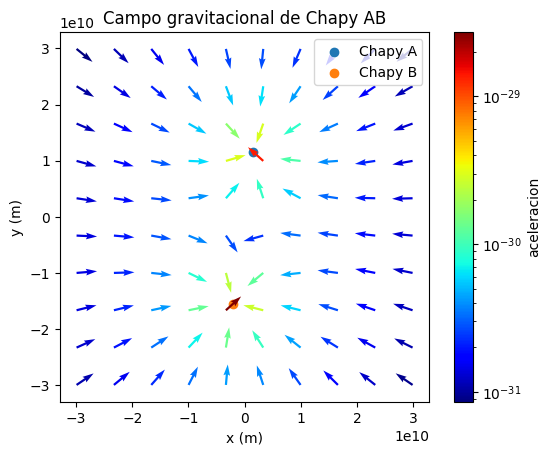

In [21]:
t = day[1]

M1 = masas_datos.loc[masas_datos['parameter'] == 'M1[M_sun]', 'value'].item()
M2 = masas_datos.loc[masas_datos['parameter'] == 'M2[M_sun]', 'value'].item()
P1 = x1[1]*AU, y1[1]*AU 
P2 = x2[1]*AU, y2[1]*AU

x0, y0, xi, yi, intensidad, cmap, norm, _ = malla_vector(P1, P2, M1, M1, xy_rang= 0.2*AU)

fig, ax = plt.subplots()

ax.set_title('Campo gravitacional de Chapy AB')

ax.scatter(P1[0], P1[1], label= 'Chapy A')
ax.scatter(P2[0], P2[1], label= 'Chapy B')

ax.legend()

ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_aspect("equal", "box")

ax.quiver(x0, y0, xi, yi, color= intensidad)
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label="aceleracion")

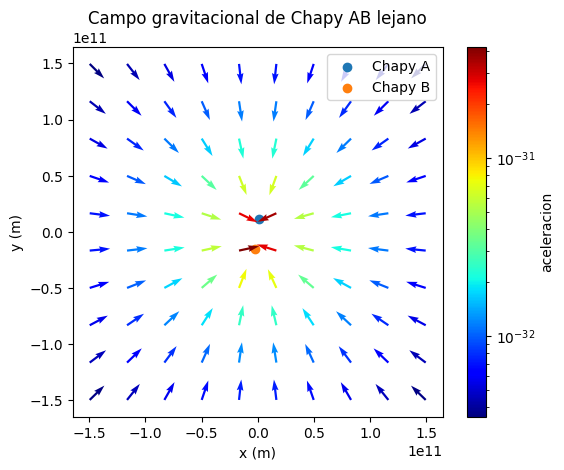

In [22]:
x0, y0, xi, yi, intensidad, cmap, norm, _ = malla_vector(P1, P2, M1, M1, xy_rang= 1*AU)

fig, ax = plt.subplots()

ax.scatter(P1[0], P1[1], label= 'Chapy A')
ax.scatter(P2[0], P2[1], label= 'Chapy B')

ax.set_title('Campo gravitacional de Chapy AB lejano')

ax.legend()

ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_aspect("equal", "box")

ax.quiver(x0, y0, xi, yi, color= intensidad)
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label="aceleracion")

In [ ]:
#Campo_local_Chapy AB.gif
t = day
x1, y1 = esf_cart(puntos['R_M1'], puntos['theta1'])
x2, y2 = esf_cart(puntos['R_M2'], puntos['theta2'])

x1 *= AU
y1 *= AU

x2 *= AU
y2 *= AU
r = 0.2*AU

x0, y0, xi, yi, intensidad, cmap, norm, _ = malla_vector((x1[0], y1[0]), (x2[0], y2[0]), M1, M2, xy_rang= r)

fig, ax = plt.subplots()

E1 = ax.scatter([], [])
E2 = ax.scatter([], [])
camp = ax.quiver(x0, y0, xi, yi, color= intensidad)

fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label="aceleracion")

ax.set_xlabel('x(m)')
ax.set_ylabel('y(m)')

ax.set_xlim(-r, r)
ax.set_ylim(-r, r)

ax.set_title('Campo gravitacional local de Chapy AB')

def init():
    E1.set_offsets(np.array([x1[0], y1[0]]))
    E2.set_offsets(np.array([x2[0], y2[0]]))

    x0, y0, xi, yi, intensidad, cmap, norm, _ = malla_vector([x1[0], y1[0]], [x2[0], y2[0]], M1, M2, xy_rang= r)

    camp.set_UVC(xi, yi)
    
    return E1, E2, camp

def update(frame):
    E1.set_offsets(np.array([x1[frame], y1[frame]]))
    E2.set_offsets(np.array([x2[frame], y2[frame]]))

    x0, y0, xi, yi, intensidad, _, _, magnitudes = malla_vector([x1[frame], y1[frame]], [x2[frame], y2[frame]], M1, M2, xy_rang= r)

    colores = cmap(norm(magnitudes))  # Esto da un color por vector

    camp.set_UVC(xi, yi)
    camp.set_color(colores)

    return E1, E2, camp

E1.set_label('Chapy A')
E2.set_label('Chapy B')

ax.legend(loc="upper right")


ani = FuncAnimation(fig, update, frames= len(day), init_func= init, blit=True)
ax.set_aspect("equal", "box")

plt.close()
HTML(ani.to_jshtml())

NameError: name 'day' is not defined

se puede notar la diferencia en la forma que toma el campo al incrementar en un orden de magnitud el espacio de muestra

Es posible medir esta distorcion, teniendo en cuenta que, en un campo que se comporta de manera radial, teniendo una superfice esferica (o una circunferencia) con el producto punto entre el vector de campo y el vector tangente a la superficie esferica (o trayectoria de circunferencia) se puede encontrar el angulo con la misma, para un campo radial este angulo debe ser cercano a 90

$$cos^{-1}(\frac{r'.c}{|r'||c|}) = \theta$$

Notese que, dependiendo del plano en el que se ubique la circunferencia el radio de transicion es diferente, asi pues, en el plano en el que se orbiten los cuerpos se podra encontrar el radio de transferencia mas grande, este es el que se tomara de manera general

In [24]:
#parametrizacion para la esfera = rcos(t), rsen(t)

circunferencia = lambda r, theta: (r*np.cos(theta), r*np.sin(theta))
v_tangente = lambda r, theta: (-r*np.sin(theta), r*np.cos(theta))

theta_values = np.linspace(0, 2*np.pi, 100)
x, y = circunferencia(1, theta_values)
xv, yv = v_tangente(1, theta_values)

Tomemos una circunferencia n de radio r alrededor del centro de masa (origen), sobre el plano principal del sistema (sobr el que orbitan las estrellas) veamos como se comporta el producto punto de los vectores tangentes y de campo a lo largo de la circunferencia, y, en especial, a medida que pasa el tiempo, pues el campo gravitacional sufrira cambios inmediatos cerca a las estrellas

In [ ]:
def cambio_campo2(xM, yM, xM2, yM2, r, M1, M2, theta_step = 1000):
    '''Calcula el producto punto del vector campo total con el vector tangente a una circunferencia de radio r, el campo total es generado por las masas 1 y 2, 
    y la circunferencia se centra en el centro de masa
    
    Entradas:
    - xM, yM = coordenadas cartesianas de la masa 1
    - xM2, yM2= coordenadas cartesianas de la masa 2
    - r: Radio de la circunferencia sobre la que se estudia el campo
    - M1: masa de la masa 1
    - M2: masa de la masa 2
    - theta_step: Pasos en los que se evalua la circunferencia

    Salidas:
    -theta_values: los valores de theta sobre los que se estudio
    -P_punto: productos punto encontrados a lo largo de la circunferencia
    '''
    rM, tM = cart_esf(xM, yM)

    rM2, tM2 = cart_esf(xM2, yM2)

    theta_values = np.linspace(0, 2*np.pi, theta_step)
    x_circ, y_circ = circunferencia(r, theta_values)
    x_vect, y_vect = v_tangente(r, theta_values)
    x_campo, y_campo = np.zeros_like(theta_values), np.zeros_like(theta_values)

    for i, (x, y) in enumerate(zip(x_circ, y_circ)):
        r, t = cart_esf(x, y)

        rC1, tC1 = F_campo(r, t, M1, r_m= rM, theta_m= tM)
        rC2, tC2 = F_campo(r, t, M2, r_m=rM2, theta_m=tM2)

        xC1, yC1 = esf_cart(rC1, tC1)
        xC2, yC2 = esf_cart(rC2, tC2)

        xC_total, yC_total = xC1+xC2, yC1+yC2

        x_campo[i], y_campo[i] = xC_total, yC_total

    vec_esferas = list(zip(x_vect, y_vect))
    vec_campo = list(zip(x_campo, y_campo))
    angulo = np.zeros_like(theta_values)

    for i in range(len(vec_campo)):
        tangente = np.array(vec_esferas[i])/la.norm(vec_esferas[i])
        campo = np.array(vec_campo[i])/la.norm(vec_campo[i])

        angulo[i] = np.degrees(np.arccos(np.dot(tangente, campo)/(la.norm(tangente)*la.norm(campo))))
    

    return theta_values, angulo

In [ ]:
#Campo_Chapy AB.gif
t = day
x1, y1 = esf_cart(puntos['R_M1'], puntos['theta1'])
x2, y2 = esf_cart(puntos['R_M2'], puntos['theta2'])

x1 *= AU
y1 *= AU

x2 *= AU
y2 *= AU
r = 0.2*AU

x0, y0, xi, yi, intensidad, cmap, norm, _ = malla_vector((x1[0], y1[0]), (x2[0], y2[0]), M1, M2, xy_rang= r)

fig, ax = plt.subplots(1, 2, figsize= (15, 5))

theta_values = np.linspace(0, 2*np.pi, 1000)
x_circ, y_circ = circunferencia(r, theta_values)
ax[0].plot(x_circ, y_circ)

E1 = ax[0].scatter([], [])
E2 = ax[0].scatter([], [])
camp = ax[0].quiver(x0, y0, xi, yi, color= intensidad)

fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label="aceleracion")

ax[0].set_xlabel('x(m)')
ax[0].set_ylabel('y(m)')

ax[0].set_xlim(-r, r)
ax[0].set_ylim(-r, r)

ax[0].set_title('Campo gravitacional y circunferencia de prueba')

line, = ax[1].plot([], [])
ax[1].set_xlim(0, 2*np.pi)
ax[1].set_ylim(20, 160)

ax[1].set_xlabel('$\\theta$ (coordenada del punto tangente en radianes)')
ax[1].set_ylabel('angulo medido (grados)')

ax[1].set_title('angulo del vector tangente y el campo')

def init():
    E1.set_offsets(np.array([x1[0], y1[0]]))
    E2.set_offsets(np.array([x2[0], y2[0]]))

    x0, y0, xi, yi, intensidad, cmap, norm, _ = malla_vector([x1[0], y1[0]], [x2[0], y2[0]], M1, M2, xy_rang= r)

    camp.set_UVC(xi, yi)

    P_M1 = [x1[0], y1[0]]
    P_M2 = [x2[0], y2[0]]

    theta_values, P_punto = cambio_campo2(P_M1[0], P_M1[1], P_M2[0], P_M2[1], r, M1, M1)
    line.set_data(theta_values, P_punto)
    
    return E1, E2, camp, line

def update(frame):
    E1.set_offsets(np.array([x1[frame], y1[frame]]))
    E2.set_offsets(np.array([x2[frame], y2[frame]]))

    x0, y0, xi, yi, intensidad, _, _, magnitudes = malla_vector([x1[frame], y1[frame]], [x2[frame], y2[frame]], M1, M2, xy_rang= r)

    colores = cmap(norm(magnitudes))  # Esto da un color por vector

    camp.set_UVC(xi, yi)
    camp.set_color(colores)

    P_M1 = [x1[frame], y1[frame]]
    P_M2 = [x2[frame], y2[frame]]

    theta_values, P_punto = cambio_campo2(P_M1[0], P_M1[1], P_M2[0], P_M2[1], r, M1, M1)
    line.set_data(theta_values, P_punto)

    return E1, E2, camp, line

E1.set_label('Chapy A')
E2.set_label('Chapy B')

ax[0].legend(loc="upper right")


ani = FuncAnimation(fig, update, frames= len(day), init_func= init, blit=True)
ax[0].set_aspect("equal", "box")

plt.close()
HTML(ani.to_jshtml())

NameError: name 'day' is not defined

En la animacion es posible ver como, para el radio escogido el angulo entre el tangente y el campo nunca es constante y oscila mas alla de 90°, Esto se traduce en un campo inestable alrededor de esos puntos, Mas aun, entre mas lejos estan los cuerpos entre si, con el objetivo de buscar el limite de transicion anteriormente mensionado y tomando en cuenta esto, buscaremos un radio tal que, en el apoastro, el angulo medido este muy cercano a 90° dentro de una tolerancia que tomaremos como $10^{-4}$

El apoastro fue extraido en la seccion de astronomia de este proyecto, el diccionario de los parametros del sistema, entontramos el la proyeccion del apoastro de las 2 masa en la vsita desde la tierra

In [27]:
R1, theta1= puntos['R_M1'], puntos['theta1']

apoastro = max(R1)

apoastro_dia = puntos[puntos['R_M1'] == apoastro]

R1_apoastro, theta1_apoastro, R2_apoastro, theta2_apoastro = apoastro_dia['R_M1'].item(), apoastro_dia['theta1'].item(), apoastro_dia['R_M2'].item(), apoastro_dia['theta2'].item()

In [28]:
R1_apoastro + R2_apoastro

0.3036548704017623

In [ ]:
def radio_transicion(xM, yM, xM2, yM2, M1, M2, r_step = 1000, tol= 1e-4):
    ''' Encuentra el radio de transicion de un sistema de 2 masas, evaluando el campo gravitacional cada 1000 metros
    
    Entradas:
    - xM, yM = coordenadas cartesianas de la masa 1
    - xM2, yM2 = coordenadas cartesianas de la masa 2
    - M1: masa de la masa 1
    - M2: masa de la masa 2
    - r_step: Pasos en los que se evalua el campo, (Por defecto en 1000, se recomienda adaptar a las magnitudes del problema)
    - tol: Valor donde se considera al producto punto como 0

    Salidas:
    -r = radio de transicion
    '''

    r = np.max([la.norm([xM, yM]), la.norm([xM2, yM2])])*2

    while True:
        cambio_max = np.max(abs(cambio_campo2(xM, yM, xM2, yM2, r, M1, M2, theta_step= 100)[1]))
        
        print(cambio_max-90)
        if cambio_max-90 <= tol:
            return r 

        r += r_step

x1_apo, y1_apo = esf_cart(R1_apoastro*AU, theta1_apoastro)
x2_apo, y2_apo = esf_cart(R2_apoastro*AU, theta2_apoastro)

radio_t = radio_transicion(x1_apo, y1_apo, x2_apo, y2_apo, M1, M2, r_step=AU*0.01, tol = 0.1)
radio_t

17.451717375171512
16.47849776936043
15.581512679530675
14.753372921213995
13.987606016282484
13.278189346636196
12.62008064208058
12.008527104364816
11.4393575965574
10.908900905719975
10.413776299602688
9.951005962504482
9.517907204374154
9.111961131044481
8.73297258702155
8.380729351179781
8.04896877394134
7.736158043407798
7.441042394173266
7.162219601602118
6.8985647872941485
6.64899104190701
6.412543581444638
6.188376024172285
5.975613238751464
5.773517344816938
5.581400393816978
5.398599178062014
5.224540385464707
5.0587283005933585
4.900591713365145
4.749709521072916
4.605608747312559
4.467901299936969
4.336317892810854
4.210341083579792
4.089714920821706
3.9742606568766092
3.863503945487693
3.7572995880423434
3.6554482824328005
3.557610263825154
3.4636434667755935
3.373343310722106
3.286453288426614
3.202861610382172
3.12242567835483
3.0450022905187524
2.9703600255657534
2.8984132102704336
2.8290960182532245
2.762214423771354
2.697612279237106
2.6353203181129317
2.575013530081

np.float64(662274880439.4624)

In [30]:
print(f'radio de transicion: {radio_t/AU} AU ±0.01AU')

radio de transicion: 4.427034137187505 AU ±0.01AU


Ahora veamos el sistema desde este radio de transicion 

In [ ]:
#Campo_Radio_t_Chapy AB.gif
t = day
x1, y1 = esf_cart(puntos['R_M1'], puntos['theta1'])
x2, y2 = esf_cart(puntos['R_M2'], puntos['theta2'])

x1 *= AU
y1 *= AU

x2 *= AU
y2 *= AU
r = radio_t

x0, y0, xi, yi, intensidad, cmap, norm, _ = malla_vector((x1[0], y1[0]), (x2[0], y2[0]), M1, M2, xy_rang= r)

fig, ax = plt.subplots(1, 2, figsize= (15, 5))

theta_values = np.linspace(0, 2*np.pi, 1000)
x_circ, y_circ = circunferencia(r, theta_values)
ax[0].plot(x_circ, y_circ)

E1 = ax[0].scatter([], [])
E2 = ax[0].scatter([], [])
camp = ax[0].quiver(x0, y0, xi, yi, color= intensidad)

fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label="aceleracion")

ax[0].set_xlabel('x(m)')
ax[0].set_ylabel('y(m)')

ax[0].set_xlim(-r, r)
ax[0].set_ylim(-r, r)

ax[0].set_title('Campo gravitacional y circunferencia de prueba')

line, = ax[1].plot([], [])
ax[1].set_xlim(0, 2*np.pi)
ax[1].set_ylim(20, 160)

ax[1].set_xlabel('$\\theta$ (coordenada del punto tangente en radianes)')
ax[1].set_ylabel('angulo medido (grados)')

ax[1].set_title('angulo del vector tangente y el campo')

def init():
    E1.set_offsets(np.array([x1[0], y1[0]]))
    E2.set_offsets(np.array([x2[0], y2[0]]))

    x0, y0, xi, yi, intensidad, cmap, norm, _ = malla_vector([x1[0], y1[0]], [x2[0], y2[0]], M1, M2, xy_rang= r)

    camp.set_UVC(xi, yi)

    P_M1 = [x1[0], y1[0]]
    P_M2 = [x2[0], y2[0]]

    theta_values, P_punto = cambio_campo2(P_M1[0], P_M1[1], P_M2[0], P_M2[1], r, M1, M1)
    line.set_data(theta_values, P_punto)
    
    return E1, E2, camp, line

def update(frame):
    E1.set_offsets(np.array([x1[frame], y1[frame]]))
    E2.set_offsets(np.array([x2[frame], y2[frame]]))

    x0, y0, xi, yi, intensidad, _, _, magnitudes = malla_vector([x1[frame], y1[frame]], [x2[frame], y2[frame]], M1, M2, xy_rang= r)

    colores = cmap(norm(magnitudes))  # Esto da un color por vector

    camp.set_UVC(xi, yi)
    camp.set_color(colores)

    P_M1 = [x1[frame], y1[frame]]
    P_M2 = [x2[frame], y2[frame]]

    theta_values, P_punto = cambio_campo2(P_M1[0], P_M1[1], P_M2[0], P_M2[1], r, M1, M1)
    line.set_data(theta_values, P_punto)

    return E1, E2, camp, line

E1.set_label('Chapy A')
E2.set_label('Chapy B')

ax[0].legend(loc="upper right")

ani = FuncAnimation(fig, update, frames= len(day), init_func= init, blit=True)
ax[0].set_aspect("equal", "box")

ani.save('Campo_Radio_t_Chapy AB.gif', writer='pillow', fps=30)

plt.close()
HTML(ani.to_jshtml())

NameError: name 'day' is not defined

Se puede alcanzar a percibir el mobimiento de los astros en el centro, sin embargo notamos que el campo practicamente no cambia, pudiendo considerarlo radial, a partir de aqui tiene sentido emplear el modelo de gravedad desde el centro de masa del sistema.